# PSU DS 200 Lab 9

In this lab, we will learn the following:
- Change the maximum depth of decision trees and evaluate them based on average f1 measure of Stratified Kfold Cross Validation
- Assess the overfitting risk of different models by comparing the performance of training data vs testing data for different maximum depth of decision tree.
- Identify the range of the best value for tree_depth parameter by considering f1 score of trainingda data and f1 score of testing data.

## Acknowledgement: This lab uses datascience Python module developed at UC Berkeley.
## The Source of Data used in this lab is an "Airline sentiment tweets" dataset from Kaggle.com.

In [1]:
!pip install datascience

     |████████████████████████████████| 51kB 3.0MB/s eta 0:00:011
     |████████████████████████████████| 92kB 2.4MB/s eta 0:00:01
     |████████████████████████████████| 13.0MB 38kB/s  eta 0:00:01      | 8.9MB 1.8MB/s eta 0:00:03
     |████████████████████████████████| 215kB 5.4MB/s eta 0:00:01
     |████████████████████████████████| 133kB 27.0MB/s eta 0:00:01
     |████████████████████████████████| 92kB 17.7MB/s eta 0:00:01
  Created wheel for datascience: filename=datascience-0.15.3-cp35-none-any.whl size=44582 sha256=57b6ecd5791a0fd136ad1620903ffa2cf7548c09259b8c1b1490c9f3f34b455f
  Stored in directory: /home/nbuser/.cache/pip/wheels/b8/37/0a/80274866028f6485c5957f0e1acf8e2b755fbe9dd0fd4ad275
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=19851 sha256=00d8dcbfa4c56fdf16721accedc543a5503555c5b3597c12546fc375bbea8512
  Stored in directory: /home/nbuser/.cache/pip/wheels/9b/04/dd/7daf4150b6d9b12949298737de9431a324d4b797ffd63f526e
Successfully built datasci

      Successfully uninstalled matplotlib-2.1.1
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import datascience
import numpy as np
import graphviz

from datascience import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics 

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

### Exercise 1 Load the Tweet File (3 points)
Use Table.read_table to load the airline_sentiment_small.csv file, whicch contain sentiment labels for airline-related tweets.

In [3]:
tweets= Table.read_table("airline_sentiment_small.csv", sep =',')
tweets

tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
Tr_tweet_973,0,0.6671,Can't Tell,0.3651,United,Austin_Grisham,0,@united don't see a justifiable cost to get on an early ...,2/23/2015 11:14,PDX,Alaska
Tr_tweet_2085,1,1,nan,nan,United,eotoro,0,@united Kurt and the crew on UA1745 were amazing today. ...,2/21/2015 14:55,"iPhone: 0.000000,0.000000",Central Time (US & Canada)
Tr_tweet_2589,0,1,Customer Service Issue,0.6804,United,bugstory,0,@united the refund team is far from customer care courte ...,2/20/2015 11:15,"Baltimore, MD",Eastern Time (US & Canada)
Tr_tweet_445,1,1,nan,nan,Virgin America,Perceptions,0,@VirginAmerica really wish you'd fly out of #Fargo @farg ...,2/17/2015 10:33,"Fargo, ND ( & Tucson, AZ)",Central Time (US & Canada)
Tr_tweet_2302,0,1,Cancelled Flight,1,United,DNLee5,0,@united my flight out of BGM Cancelled Flightled last ni ...,2/21/2015 2:21,"New York, US; Tanzania, Africa",Central Time (US & Canada)
Tr_tweet_1111,1,0.6289,nan,0,United,sentientcheese,0,"@united been solved, they finally picked up the second ...",2/23/2015 7:20,nan,nan
Tr_tweet_1734,0,1,Cancelled Flight,0.684,United,ATL_Attorney,0,@united involuntarily bumped your passenger and can't gu ...,2/22/2015 7:54,"Atlanta, GA",Quito
Tr_tweet_138,0,1,Damaged Luggage,1,Virgin America,khartline,0,.@VirginAmerica does that mean you don't have a policy f ...,2/22/2015 12:27,Las Vegas,Pacific Time (US & Canada)
Tr_tweet_1963,0,0.684,Customer Service Issue,0.3499,United,Jo_Frost,0,@united when I read it say ' in some cases' can you plea ...,2/21/2015 19:12,Global,Quito
Tr_tweet_718,0,1,Customer Service Issue,1,United,fortytoo,0,"@united tried calling too, but w/25 min phn wait means w ...",2/23/2015 20:36,"WX report for 41 Mile, Hwy 50",Pacific Time (US & Canada)


In [4]:
X = tweets['text']
X

array(["@united don't see a justifiable cost to get on an early flight with seats. No airline charges to conveniently get their passengers in early",
       "@united Kurt and the crew on UA1745 were amazing today. They made my son's birthday with their kindness. Hope to fly with them again soon!",
       "@united the refund team is far from customer care courtesy they need training on work ethics. So it's like sir u r lying how can I help",
       "@VirginAmerica really wish you'd fly out of #Fargo @fargoairport those fares are amazings",
       '@united my flight out of BGM Cancelled Flightled last night, I get a hotel voucher, but had to pay for a cab back. Worse cab experience ever',
       '@united been solved,  they finally picked up the second time I called,  thanks for the response JH!  7:21 to dulles works!',
       "@united involuntarily bumped your passenger and can't guarantee them another flight for three days!",
       ".@VirginAmerica does that mean you don't have a polic

In [5]:
y = tweets['airline_sentiment']
y

array([0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
       1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0.

### Exercise 2 (5 points)
Choose a percentage (e.g., 0.2, 0.25, or 0.3) for splitting the data into training and testing.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
print(X_train)

['@united but then again, maybe the @BBBNE_SD_KS_IA would care more to hear what went on than whoever listens to issues you caused'
 "@united Great! I'm ready to go home."
 '@united I was protected on that flight by gate agent Kerry at LAS. She also did an excellent job getting me to my destination today. Thanks!'
 "@united Okay thanks if you could please update me. I was told at the airport someone would call me today but they haven't."
 "@united - you sure missed the mark on tonight's redeye from LAX to Chicago. What a mess! You can do better!"
 '@united worked out after all. Thanks for your immediate reply!!'
 '@united contd... I am being told that I am asking for a refund on a used ticket on a flight that got Cancelled Flightled how is the ticket used?'
 '@united how can you not put my bag on plane to Seattle. Flight 1212. Waiting  in line to talk to someone about my bag. Status should matter.'
 "@united can you help from there? UA4935 can't take off without missing galley cart tha

### Use CountVectorizer in sklearn to convert text of each tweet into a word frequency representation 
In Lab 3, we used CountVectorizer to convert a set of short texts into a word frequency matrix representation.  If you do not recall word frequency representation, you may want to revisit Lab 3 to refresh your memory.  In this lab, we are
also going to use CountVectorizer to convert a set of real tweets into a word frequency matrix representation.  We made two improvements to the way we convert text to word frequency matrix in Lab 3.
- Because real tweets contain non-alphanumeric characters such as emojis, we use a regular expression to extract all alphanumeric words, hashtags, and Twitter users (i.e., @...) mentioned in a tweet, ignore the other non-alphanumeric characters.  You do not need to understand the details of how this regulare expression is constructed.  You just need
to understand their function.
- Because the number of tweets are large, we do not want to include any word that occurs only in ONE tweet (why?). 
To do this, we use set "minimum document frequency" (min_df) to be 2.  "Documents" refers to, in this case, tweets.

In [7]:
count_vect = CountVectorizer(token_pattern= '((?:([@#]|[0-9]|[a-z]|[A-Z])+))', analyzer= 'word', min_df=2)

In [8]:
X_word_vect = count_vect.fit_transform(X_train)

In [9]:
print(X_word_vect.shape)

(480, 998)


### Iterate over multiple values for the parameter max_depth of decision trees.
We will use "for loop" in Python to iterate over different possible values for the max_depth
parameter.

#### To iterate over a range of integer (say from 5 to 40), we can use the following code in Python:
    for d in range(5, 41):
        print(d)
The variable "d" is initially set to the minimum value of the range (i.e., 5 in the example
above).  After executing the body of the "for loop" once, the variable "d" is incrased by 1
(i.e., becomes 6), then it executes the body of the "for loop" for the second time. These two 
steps (i.e., executing the body of the for loop, increase the value of "d" by 1) iterate until
the value of the variable "d" reaches the maximum number of the range (i.e., 41 in the example
above).

#### Notice: The ':' at the end of for statement is important.
#### The body of the for loop (i.e., 'print(d)' in this example) is indented to the right.
    
The example below contains a for loop with a simple body that prints the value of the d.

### Exercise 1 Iteration (4 points)
Set the minimum value and the maximum value of the range, make sure they are both integers and the 
maximum value is higher than the minimum value. Execute the for loop.
- (1) What is the value of d in the last iteration?
- (2) What is the relationship between the maximum value and the value of d in the last iteration?

In [10]:
for d in range(3, 21): 
    print (d)

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


### Answer to Exercise 1: 
- (1)The value of d in the last iteration is 20.
- (2)The last iteration value is the value of maximum value - 1.

In [11]:
import pandas as pd
from pandas import *
from numpy import *

### Exercise 2 Part A
Choose a ragne of max_depth to generate and evaluate the decision tree for each max_depth using both training data and testing data.
- Choose the value of the low_max_depth and high_max_depth below, which determines the range of max_depth you will use to construct decision trees.
- Execute the following code cells that generate the figure that shows the performance of f1 score for training data and testing data for each choice of max_depth.

In [28]:
low_max_depth = 1
high_max_depth = 40
training_performance_table = np.empty( [high_max_depth+1, 4] )
testing_performance_table = np.empty( [high_max_depth+1, 4] )

In [29]:
# Prepare the word frequency matrix for the testing data, since it is 
# identical for every iteration of the for loop.

X_test_word_vect = count_vect.transform(X_test)
                                                
for depth in range(low_max_depth, high_max_depth+1):
    # Create the decision tree using a specific value for max_depth parameter
    clf = tree.DecisionTreeClassifier(criterion='entropy', random_state = 100, max_depth=depth, \
                                  min_samples_leaf =2)
    clf.fit(X_word_vect, y_train)
    
    ### Use the model generated to predict for training data
    predicted_training_y = clf.predict(X_word_vect)
#   print("Max Depth is ", depth, "Prediction Performance for Training Data")
    train_p = metrics.precision_score(y_train, predicted_training_y)
    train_r = metrics.recall_score(y_train, predicted_training_y)
    train_f1 = metrics.f1_score(y_train, predicted_training_y)
    training_performance_table[depth,0] = depth
    training_performance_table[depth,1] = train_p
    training_performance_table[depth,2]= train_r
    training_performance_table[depth,3]= train_f1
    
    ### Use the model generated to predict for testing data
    predicted_testing_y = clf.predict(X_test_word_vect)
#   print("Prediction Performance for Testing Data")
    test_p = metrics.precision_score(y_test, predicted_testing_y)
    test_r = metrics.recall_score(y_test, predicted_testing_y)
    test_f1 = metrics.f1_score(y_test, predicted_testing_y)
    testing_performance_table[depth,0] = depth
    testing_performance_table[depth,1] = test_p
    testing_performance_table[depth,2] = test_r
    testing_performance_table[depth,3] = test_f1


### Visualizing the performance for different max_depth


In [30]:
print(training_performance_table[low_max_depth:high_max_depth,3])

[0.27835052 0.53386454 0.65505226 0.70877193 0.74452555 0.76470588
 0.77037037 0.77941176 0.80144404 0.80144404 0.81978799 0.81850534
 0.82807018 0.86006826 0.88963211 0.88963211 0.90849673 0.90849673
 0.92581602 0.92258065 0.93413174 0.93290735 0.93968254 0.94637224
 0.94637224 0.94637224 0.95121951 0.95705521 0.95652174 0.95652174
 0.95652174 0.95652174 0.95652174 0.95652174 0.95652174 0.95652174
 0.95652174 0.95652174 0.95652174]


In [31]:
print(testing_performance_table[low_max_depth:high_max_depth,3])

[0.15789474 0.4        0.73529412 0.8125     0.81967213 0.81967213
 0.81967213 0.81967213 0.85714286 0.85714286 0.80645161 0.85714286
 0.84375    0.84375    0.875      0.875      0.81818182 0.8358209
 0.72727273 0.8358209  0.75324675 0.8115942  0.79411765 0.82857143
 0.82857143 0.82857143 0.75675676 0.77333333 0.77777778 0.79452055
 0.79452055 0.79452055 0.79452055 0.79452055 0.79452055 0.79452055
 0.79452055 0.79452055 0.79452055]


In [32]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

In [33]:
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [34]:
f1_training = training_performance_table[low_max_depth:high_max_depth+1, 3]
f1_testing = testing_performance_table[low_max_depth:high_max_depth+1, 3]
depth = np.linspace(low_max_depth, high_max_depth, high_max_depth-low_max_depth+1)
print(depth)
print(f1_training)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40.]
[0.27835052 0.53386454 0.65505226 0.70877193 0.74452555 0.76470588
 0.77037037 0.77941176 0.80144404 0.80144404 0.81978799 0.81850534
 0.82807018 0.86006826 0.88963211 0.88963211 0.90849673 0.90849673
 0.92581602 0.92258065 0.93413174 0.93290735 0.93968254 0.94637224
 0.94637224 0.94637224 0.95121951 0.95705521 0.95652174 0.95652174
 0.95652174 0.95652174 0.95652174 0.95652174 0.95652174 0.95652174
 0.95652174 0.95652174 0.95652174 0.95652174]


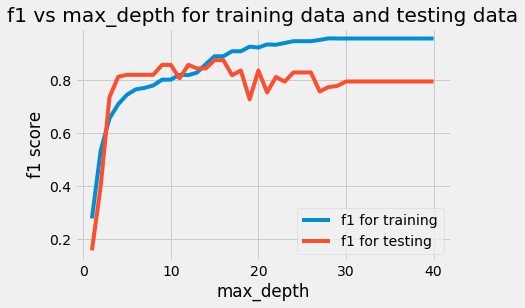

In [35]:
plt.plot(depth, f1_training, label="f1 for training")
plt.plot(depth, f1_testing, label="f1 for testing")
plt.xlabel('max_depth')
plt.ylabel('f1 score')
plt.title('f1 vs max_depth for training data and testing data')
plt.legend()
plt.show()

### Exercise 2 Part B (16 points)
Answer the following questions based on the results you obatined:
- (1) What is the range of max_depth that you believe can give the best performance?
- (2) What is the range of max_depth that you believe indicate overfitting?  Explain your answer.
- (3) Is there a general relationship between max_depth and f1 score of training data?  Explain your answer.
- (4) Is there a general relationship between max_depth and f1 score of testing data? Explain your answer.

### Answer to Exercise 2 Part B
- (1)The range for best performance would be between 12 to 15.
- (2)The range of overfitting would be between 17 to 40.
- (3)The bigger of the max_depth is, the better the f1 score of training data is, until it hits true max_depth and stays flat.
- (4)The test data performs better while max_depth increases until the max_depth hits a certain point, in this case, 15, then its f1 score starts to decrease. Then it reaches the true max_depth and it stays flat.